In [59]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
%matplotlib inline

In [65]:
#Set the style for latex-like plots
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [14]:
# Read results from pickles.
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
metrics = {}
timings = {}

for m in metrics_names:
    metrics[m] = {}
for s in seeds:
    with open("data/pkl/{seed}/precisions.pkl".format(seed=s), "rb") as f:
        metrics['precision'][s] = pickle.load(f)
    with open("data/pkl/{seed}/recalls.pkl".format(seed=s), "rb") as f:
        metrics['recall'][s] = pickle.load(f)
    with open("data/pkl/{seed}/f1_scores.pkl".format(seed=s), "rb") as f:
        metrics['f1_score'][s] = pickle.load(f)
    with open("data/pkl/{seed}/timings.pkl".format(seed=s), "rb") as f:
        timings[s] = pickle.load(f)

## Mean metric by iteration
Compute the mean of the measurements obtained for every metric and every seed, divided by the iteration.
Plot for all metrics and seeds the trend of the means, with error-bars.

In [9]:
def compute_mean_and_std_by_metric(metric: list):
    """
    Compute the mean and the standard deviation for each metric,
    grouped by every iteration of the algorithm.
    
    Arguments:
        metric: the name of the metric, among 'precision', 'recall' and 'f1_score' 
    Returns:
        
    """
    metric_means = []
    metric_stds = []   
    last_iter = max(metric[0].keys()) + 1
    for i in range(last_iter):
        iter_values = [val[i] for val in metric]
        metric_means.append(np.mean(iter_values))
        metric_stds.append(np.std(iter_values))
    return metric_means, metric_stds

Text(0.5, 3.35, 'Metrics behaviour among the iterations')

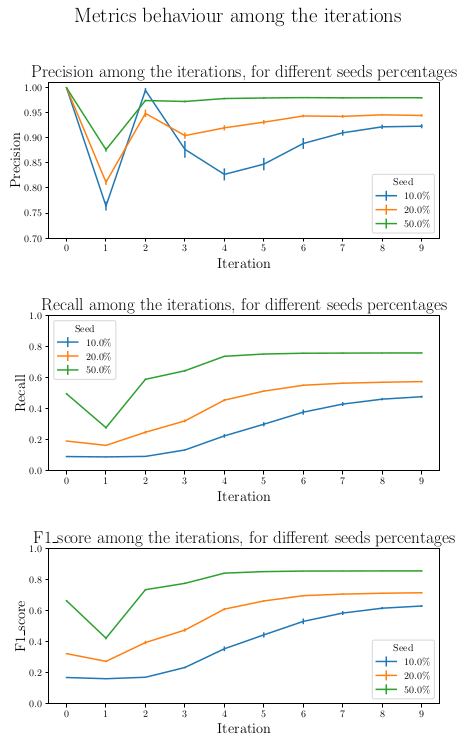

In [31]:
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
title = "{} among the iterations, for different seeds percentages"
fig, axarr = plt.subplots(3, 1, figsize=(7,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.5)
for i, metric in enumerate(metrics_names):
    for s in seeds:
        metric_means, metric_std = compute_mean_and_std_by_metric(metrics[metric][s])
        axarr[i].set_title(title.format(metric.capitalize()), fontsize=18)
        axes = plt.gca()
        if metric=="precision":
            axarr[i].set_ylim([0.7,1.01])
        else:
            axarr[i].set_ylim([0,1])
        axarr[i].set_xticks(range(10))
        axarr[i].set_xlabel("Iteration", fontsize=15)
        axarr[i].set_ylabel(metric.capitalize(), fontsize=15)
        axarr[i].errorbar(range(len(metric_means)), metric_means, yerr=metric_std, label=str(float(s)*100)+"%")
    axarr[i].legend(title="Seed")
fig.suptitle("Metrics behaviour among the iterations", y = 3.35, size=20)

In [21]:
# print metric/seed pair mean and stds
for metric in metrics_names:
    print("\nMetric: {}".format(metric.capitalize()))
    for s in seeds:
        metric_means, metric_stds = compute_mean_and_std_by_metric(metrics[metric][s])
        metric_mean, metric_std = metric_means.pop(), metric_stds.pop()
        # Print mean and std of the metric for the given seed (only last iteration printed for simplicity)
        print("    Seed:", str(float(s)*100)+"%")
        print("        Last Iteration Mean:", metric_mean)
        print("        Last Iteration Std:", metric_std)


Metric: Precision
    Seed: 10.0%
        Last Iteration Mean: 0.9233009952766418
        Last Iteration Std: 0.004149546448537433
    Seed: 20.0%
        Last Iteration Mean: 0.9447710375986847
        Last Iteration Std: 0.002438021125866156
    Seed: 50.0%
        Last Iteration Mean: 0.9801147498188701
        Last Iteration Std: 0.0011171672043645434

Metric: Recall
    Seed: 10.0%
        Last Iteration Mean: 0.47795811925891335
        Last Iteration Std: 0.00660099552268535
    Seed: 20.0%
        Last Iteration Mean: 0.5754164720535575
        Last Iteration Std: 0.0046278719099872275
    Seed: 50.0%
        Last Iteration Mean: 0.7597189786704034
        Last Iteration Std: 0.0029181351539411754

Metric: F1_score
    Seed: 10.0%
        Last Iteration Mean: 0.6298300362902959
        Last Iteration Std: 0.005743956555303411
    Seed: 20.0%
        Last Iteration Mean: 0.715213864177381
        Last Iteration Std: 0.0038818424110766137
    Seed: 50.0%
        Last Iteration M

## Time for seed
Plot the average time (with confidence intervals) for every experiment, divided by seed.

In [67]:
plt.figure(figsize=(15,8))
plt.title("Time measuration per experiment", fontsize=14)
plt.boxplot([timings[s] for s in seeds], labels=[str(float(s)*100)+"% Seed" for s in seeds])
plt.ylabel("Timing measurement from PARIS $[ ms ]$")
plt.xlabel("Chosen seed percentage");

In [19]:
# Print mean and std of timings
for s in seeds:
    print("Seed: ", str(float(s)*100)+"%")
    mean_timings = np.mean(timings[s])
    std_timings = np.std(timings[s])
    print("    Mean (s): ", mean_timings/1000)
    print("    Std  (s): ", std_timings/1000)

Seed:  10.0%
    Mean (s):  37.532599999999995
    Std  (s):  3.3989368543707896
Seed:  20.0%
    Mean (s):  39.567800000000005
    Std  (s):  2.1072487892985015
Seed:  50.0%
    Mean (s):  51.522949999999994
    Std  (s):  2.0500965215081948


## Confidence interval of last iteration's metrics
Plot the 95% confidence interval by bootstrapping the results obtained in the last iteration, for every metric and seed.

In [13]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list to be used for computing confidence intervals
        using bootstrap resample"""
    means = []
    if type(metric_list[0]) is dict:
        last_iter = max(metric_list[0].keys())
        metric_last = [val[last_iter] for val in metric_list]
    else:
        metric_last = metric_list
    for i in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [14]:
def confidence_interval(means, conf_percent):
    # Computing low quantile (2.5 in our case)
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [15]:
def plot_confidence(means_metric, mean, interval, title, xlabel):
    
    # Plot scores
    plt.hist(means_metric, bins=25)

    # Plot of two interval lines
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")

Confidence interval found for Precision - Seed 10.0%: [0.9215134262652437 - 0.9252649937097517]
Confidence interval found for Precision - Seed 20.0%: [0.943725006964897 - 0.9458838655650147]
Confidence interval found for Precision - Seed 50.0%: [0.9796229367372357 - 0.9806258817989515]
Confidence interval found for Recall - Seed 10.0%: [0.47507366106180915 - 0.48069963412735484]
Confidence interval found for Recall - Seed 20.0%: [0.5734391055581504 - 0.5774525144013702]
Confidence interval found for Recall - Seed 50.0%: [0.7584710221080493 - 0.7609061186361513]
Confidence interval found for F1_score - Seed 10.0%: [0.6275394975234508 - 0.63244393473362]
Confidence interval found for F1_score - Seed 20.0%: [0.7134777947208132 - 0.7168748986651441]
Confidence interval found for F1_score - Seed 50.0%: [0.8550285242875167 - 0.8568337071835297]


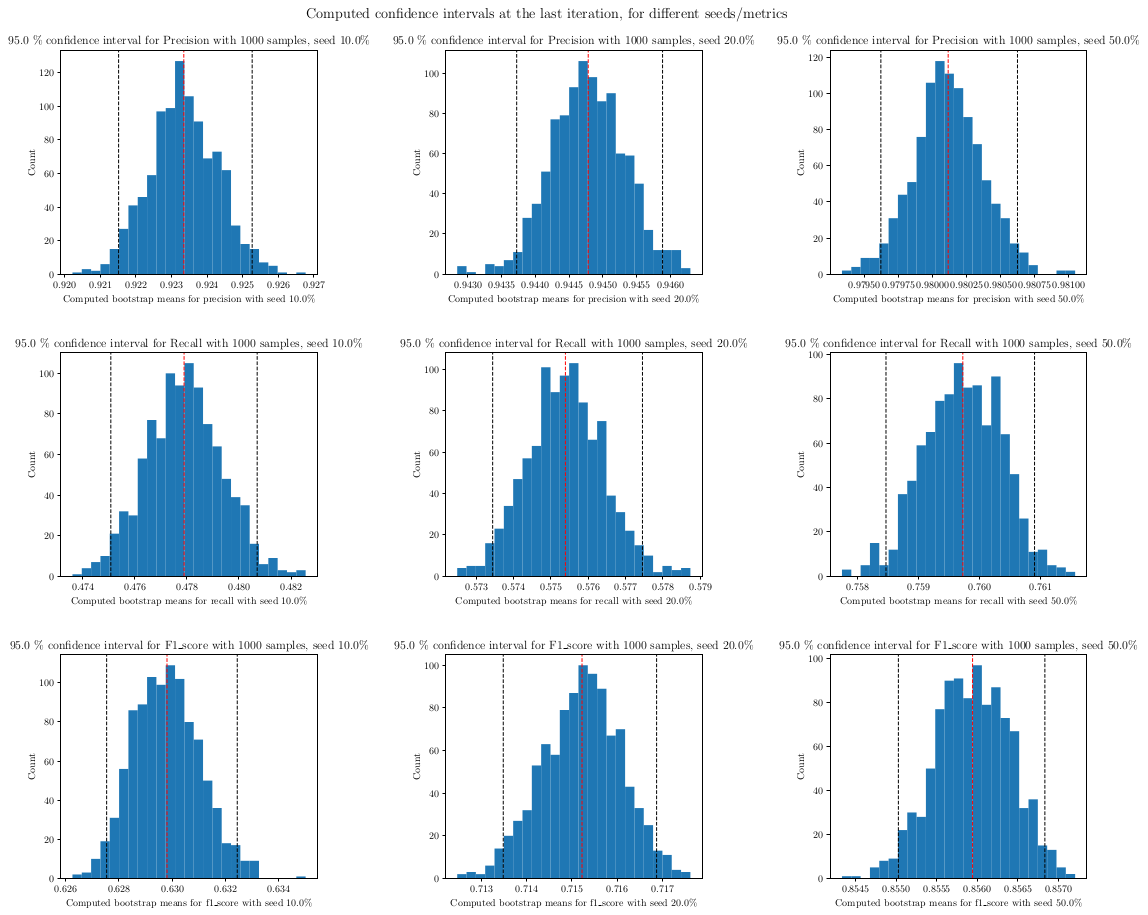

In [67]:
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']
index = 1
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.5, hspace=0.35)

for m in metrics_names:
    for s in seeds:
        means_metric = bootstrap_metric(metrics[m][s], 1000)
        interval = confidence_interval(means_metric, 0.95)
        print("Confidence interval found for {metric} - Seed {seed}: [{low_inter} - {high_inter}]".format(metric=m.capitalize(), seed=str(float(s)*100)+"%", \
                                                                                                                low_inter=interval[0], high_inter=interval[1]))
        mean = np.mean(means_metric)
    
        plt.subplot(3, 3, index)
        plot_confidence(means_metric, mean, interval,\
                        "$95.0$ % confidence interval for {metric} with 1000 samples, seed {seed}".format(metric=m.capitalize(), seed = str(float(s)*100)+"%"),\
                        "Computed bootstrap means for {metric} with seed {seed}".format(metric=m, seed=str(float(s)*100)+"%"))
        index += 1 
fig.suptitle("Computed confidence intervals at the last iteration, for different seeds/metrics", y = 3.15, x=1.25, size=14);

## Confidence interval of timings
Plot the 95% confidence interval by bootstrapping the timing result, for each seed.

Confidence interval found for timings - Seed 10.0%: [35992.817500000005 - 39032.80125]
Confidence interval found for timings - Seed 20.0%: [38636.99625 - 40408.92999999999]
Confidence interval found for timings - Seed 50.0%: [50544.377499999995 - 52375.96125000001]


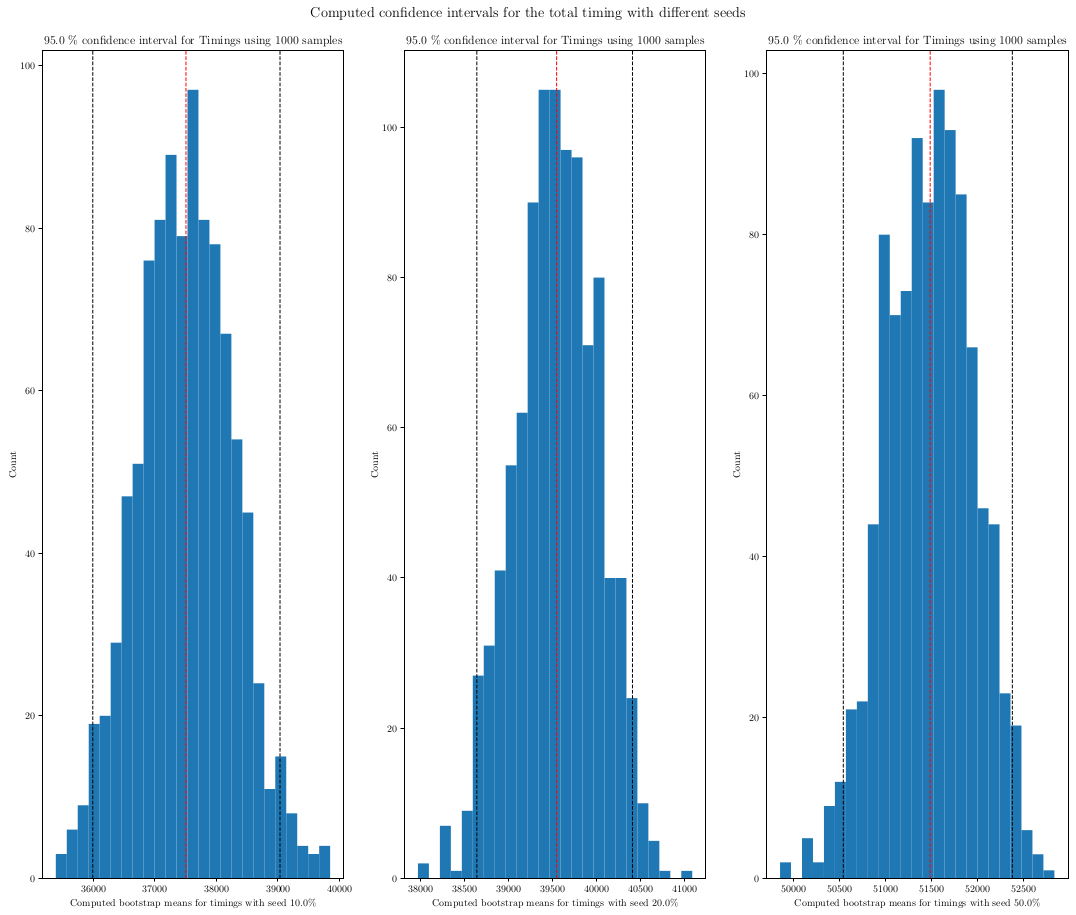

In [68]:
seeds = ['0.1', '0.2', '0.5']
index = 1
fig, axarr = plt.subplots(1, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.2, hspace=0.35)

for s in seeds:
    means_timings = bootstrap_metric(timings[s], 1000)
    interval = confidence_interval(means_timings, 0.95)
    print("Confidence interval found for timings - Seed {seed}: [{low_inter} - {high_inter}]".format(seed=str(float(s)*100)+"%", \
                                                                                                        low_inter=interval[0], high_inter=interval[1]))
    mean = np.mean(means_timings)

    plt.subplot(1, 3, index)
    plot_confidence(means_timings, mean, interval,\
                    "$95.0$ % confidence interval for Timings using 1000 samples",\
                    "Computed bootstrap means for timings with seed {seed}".format(seed=str(float(s)*100)+"%"))
    index += 1 
fig.suptitle("Computed confidence intervals for the total timing with different seeds", y = 3.15, x=1.25, size=14);

## Plot the errors for last's iterations metrics
Plot the means (and relative errors) for the metrics obtained during the last iteration, for every metric and seed.

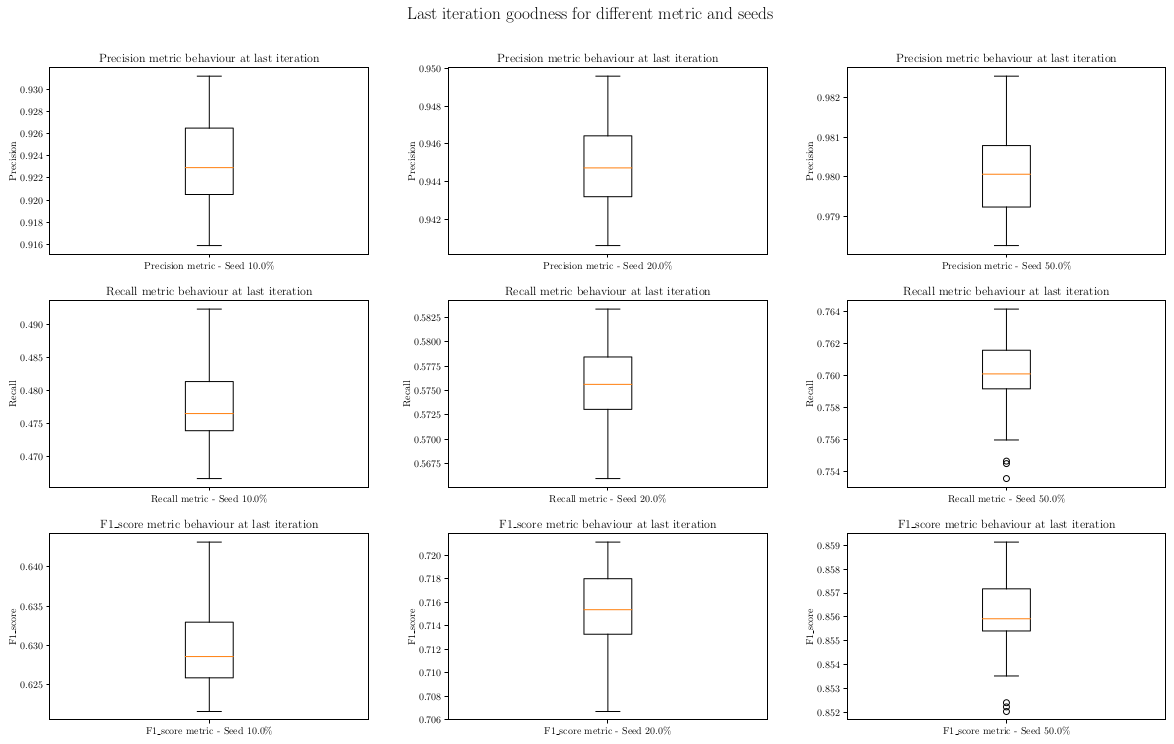

In [66]:
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.25, hspace=0.25)
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']

iterator = 1
for m in metrics_names:
    for s in seeds:
        last_iter = max(metrics[m][s][0].keys())
        metric_last = [val[last_iter] for val in metrics[m][s]]
        plt.subplot(3, 3, iterator)
        plt.boxplot([metric_last], labels=["{metric} metric - Seed {seed}".format(metric=m.capitalize(), seed=str(float(s)*100)+"%")])
        plt.ylabel(m.capitalize())
        plt.title("{} metric behaviour at last iteration".format(m.capitalize()))
        iterator += 1 
fig.suptitle("Last iteration goodness for different metric and seeds", y = 3.15, x=1.25, size=14);